<a href="https://colab.research.google.com/github/estebanhernandezr/Entregas-Semanales/blob/main/AndreyEsteban_LizarazoHernandez_ejerciciosCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A continuación, **importamos** las **librerías** necesarias...

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

A continuación, **importamos** el **dataset iris**, los **regresores** y el **target** en dataframes por separado y luego los **concatenamos** en un solo **dataframe**...

In [82]:
# Dataset IRIS
iris = datasets.load_iris()
# Regresores
df_observ = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# Target (0=setosa, 1=versicolor, 2=virginica)
df_target = pd.DataFrame(data=iris.target, columns=['label'])
df_target['name'] = df_target['label'].apply(lambda x: iris.target_names[x])
# Dataframe completo (regresores junto a su etiqueta correspondiente)
df_comple = pd.concat([df_observ, df_target], axis=1)
df_comple

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Tenemos un **dataframe** compuesto por **150 observaciones** de **4 características** y **una etiqueta** (**label** + **name**). Cuando graficamos dos de las características (**petal length** y **petal width**), podemos ver cómo se separan los datos en las **3 clases** distintas: **setosa**, **versicolor** y **virginica**.

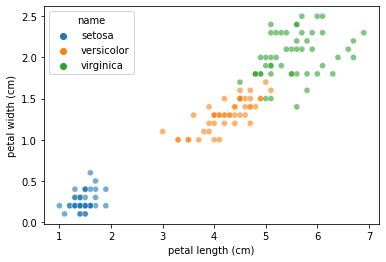

In [83]:
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', hue='name', data=df_comple, alpha=0.6);

A continuación, podemos ver la **proyección** de los datos sobre el **eje y**.

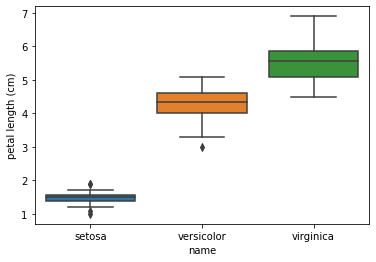

In [84]:
sns.boxplot(y='petal length (cm)', x='name',data=df_comple);

A continuación, podemos ver la **proyección** de los datos sobre el **eje x**.

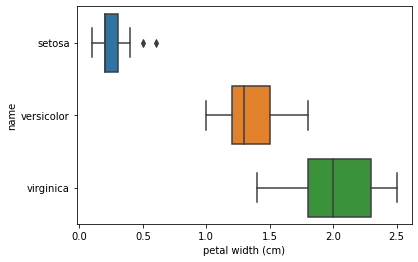

In [85]:
sns.boxplot(x='petal width (cm)', y='name',data=df_comple);

Podemos comprobar cómo las características **petal width** y **petal length** separan satisfactoriamente las 3 clases: sus medias están separadas y sus variaciones son lo suficientemente pequeñas que no se sobrelapan demasiado. 

Debido a que las clases se separan lo suficientemente bien con las dos características **petal width** y **petal length**, usaremos solo estas dos para entrenar tres modelos diferentes: **KNN**, **Regresión Logistica** y **K-means**.

A continuación, separamos el dataframe en **datos de prueba** y **datos de entrenamiento**.

In [86]:
# Dataframe con columnas "petal width" y "petal length" de 150 observaciones
X = df_observ.iloc[:, 2:]
# Dataframe columna "label" de 150 observaciones
y = df_target.iloc[:, 0]
# Separación de los datos en datos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

En la siguiente celda de código, definimos algunas **funciones** que serán de utilidad para **evaluar** las siguientes características del modelo:
*   **Exactitud**
*   **Precisión**
*   **Sensibilidad**
*   **Especificidad**
*   **Proporción de falsos positivos**

Para esto, las funciones a continuación reciben como entrada el vector de etiquetas predichas por algún modelo y el vector de etiquetas fácticas para el conjunto de datos de prueba. De esta manera, podemos saber cuántos falsos positivos en la predicción tuvo el modelo, así como cuántos falsos negativos. Esto último, nos permitirá calcular las medidas de correctitud del modelo y evaluarlo de la manera más objetiva posible.





In [106]:
# Nice function to calculate and visualize the confusion matrix
def plotCM(ytrue, ypred, labels):    
    CM = confusion_matrix(ytrue, ypred)
    
    ax = sns.heatmap(CM, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

A continuación, definimos algunas funciones que permiten entrenar los siguientes modelos, recibiendo como entrada algunos de los hiper-parámetros para los modelos y retornan los modelos entrenados con esos hiper-parámetros de entrada:
1.   **KNN** ( ***hyper-parámetros:*** número de vecinos **+** métrica de cercania )
2.   **Regresión Logística** (***hyper-parámetros:*** learning rate )
3.   **K-means** ( ***hyper-parámetros:*** número de clusters **+** métrica dissimilaridad )






In [88]:
def generate_knn_model(k, dist='euclidean'):
    print('generating knn model with hyper-parameters: ', k, ' y ', dist)
    knn_model = KNeighborsClassifier(n_neighbors=k, metric=dist)
    knn_model.fit(X_train, y_train)
    return knn_model

def generate_logic_regression_model(learn_rate):
    print('generating logistic regression model with hyper-parameters: ', learn_rate)
    log_reg_model = LogisticRegression()
    log_reg_model.fit(X_train, y_train)
    return log_reg_model

def generate_kmeans_model(n):
    print('generating k means model with hyper-parameters: ', n)
    kmeans_model = KMeans(n_clusters=n, random_state=10)
    kmeans_model.fit(X_train)
    return kmeans_model

In [103]:
modelo = generate_knn_model(3)
predicciones = modelo.predict(X_test)

generating knn model with hyper-parameters:  3  y  euclidean


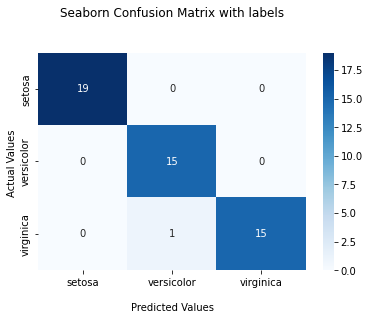

In [110]:
plotCM(y_test, predicciones, sorted(iris.target_names))